# Calculate Kd from PBM data
This program calulates the absolute Kd that a TF has for each PBM sequence
We do this for sequences with a Gal4p site and for sequences without a canonical site (have CGG half sites).

Written by NJM, PSR, RDM

In [1]:
from analyze_sig_hits_v2 import *
import pandas as pd
import numpy as np
import itertools
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Alphabet.IUPAC import unambiguous_dna, ambiguous_dna 
from Bio import SeqUtils

In [3]:
#Take in sequence add applys a score to each seq based on PWM cutoff
def add_recommended_score(df, cutoff = 13.01, tf = 'Gal4'):
	df["Score"] = df["Sequence"].apply(lambda x: get_max_pwm_score(x,tf))
	#newdf = df[df["Score"]<cutoff]
	return df

In [4]:
#removed all seq with a canonical motif from df
def removeCannon(df, cutoff = 13.01, tf = 'Gal4'):
	df["Score"] = df["Sequence"].apply(lambda x: get_max_pwm_score(x,tf))
	newdf = df[df["Score"]<cutoff]
	return newdf
#counts the number of CGG half sites in seq
def getCGG(inSeq):
	seq = Seq(str(inSeq), IUPAC.unambiguous_dna)
	n = 0
	while(seq.find("CGG")>=0):
		i = seq.find("CGG")
		seq = seq[i+3:]
		n = n+1
	seq = Seq(str(inSeq), IUPAC.unambiguous_dna)
	seq = seq.reverse_complement()
	while(seq.find("CGG")>=0):
		i = seq.find("CGG")
		seq = seq[i+3:]
		n = n+1
	return n

In [5]:
#Robs analyze nuc hormone code
def FindConsensusMotif(consensusMotif,input_sequence):
    
    ''' This function takes as input a "consensus motif", which is essentially a consensus sequence,
    but with Ns,Rs,Ys,Ks, and a sequence to scan. It will scan the sequence and return 
    a list of tuples that give the start and stop coordinates of all instances of the 
    consensus motif, on both strands of course.
    
    The consensusMotif variable can be passed to this function a string or a Seq object 
    The input_sequence variable can also be baseed as a string or Seq object'''

    input_sequence = Seq(str(input_sequence),ambiguous_dna)
    consensusMotif = Seq(str(consensusMotif),ambiguous_dna)
    
    #find all instances of consensus motif in forward strand of the sequence
    start_positions_forward = SeqUtils.nt_search(str(input_sequence), str(consensusMotif))[1:]
    
    #find all instances of consensus motif in the reverse strand of the sequence
    
    #first, take the reverse complement of the consensus motif
    rc_consensusMotif = consensusMotif.reverse_complement()
    
    if rc_consensusMotif == consensusMotif: #if consensusMotif is palindromic, don't search reverse strand
        end_positions_reverse = []
    else:
        end_positions_reverse = SeqUtils.nt_search(str(input_sequence), str(rc_consensusMotif))[1:]
    
    #output list of lists giving start and end positions of all motif 
    #instances.  For instance on the forward strand, start < end.  
    #For reverse strand, start > end.  The indices are zero indexed.
    output_list = []
    for startpos in start_positions_forward:
        position_list = [startpos,startpos+len(consensusMotif)-1]
        output_list.append(position_list)
    
    for endpos in end_positions_reverse:
        position_list = [endpos+len(consensusMotif)-1,endpos]
        output_list.append(position_list)
    
    return output_list

    
    
def countSites(hit_list):
    return len(hit_list)

def countSites_maxdisjoint(hit_list):
    #we no longer need the strand information
    #and we need the coordinates to be in smallest
    #to largest order to properly sort the intervals
    #for the maximal disjoint intervals problem.
    #so first step is to make sure all coordinates
    #are smallest to largest
    
    for index,sublist in enumerate(hit_list):
        hit_list[index].sort()
    
    #now sort by endpoint
    
    hit_list = sort_hitlist_by_endpoint(hit_list)
    
    index = 0
    while index < len(hit_list)-1:
        #print(hit_list) uncomment this print for debugging
        #does the nth element overlap the n+1 th element?
        if hit_list[index][1] >= hit_list[index+1][0]:
            #if there is overlap, then find
            #which element has the smaller end coordinate
            if hit_list[index][1] <= hit_list[index+1][1]:
                #remove n+1th element, don't advance index
                hit_list.pop(index+1)
            else:
                #remove nth element, don't advance index
                hit_list.pop(index)
        else:
            #if there is no overlap, advance the index
            index = index + 1
    return len(hit_list)
   
    
def sort_hitlist_by_endpoint(hit_list): 
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    hit_list.sort(key = lambda x: x[1]) 
    return hit_list






sns.set()
sns.set_style("ticks")
sns.set_context('notebook') #must be in 'paper', 'notebook', 'talk', 'poster'

def compute_binding_v_sites(PBMframe,consensus_site,canonical_site = "N/A",median=False,overlapping_sites=False,path = "PBM_data/"):
    
    #PBMframe = pd.read_csv(filename,sep="\t",header=None)
    #PBMframe = pd.read_csv(filename,sep="\t",header=None,names=["binding_score","sequence"])


    
    if canonical_site != "N/A":
        PBMframe = remove_canon(PBMframe,canonical_site)
    if overlapping_sites:
        PBMframe["num_sites"] = PBMframe.sequence.apply(lambda x: countSites(FindConsensusMotif(consensus_site,x)))
    else:
        PBMframe["num_sites"] = PBMframe.sequence.apply(lambda x: countSites_maxdisjoint(FindConsensusMotif(consensus_site,x)))
    if median:
        return PBMframe.groupby("num_sites").median(),PBMframe
    return PBMframe
#     else:
#         return PBMframe.groupby("num_sites").mean(),PBMframe

def remove_canon(PBMframe,canonical_site):
    PBMframe["canonical_sites"] = PBMframe.sequence.apply(lambda x: countSites(FindConsensusMotif(canonical_site,x)))
    #return PBMframe
    PBMframe = PBMframe[PBMframe["canonical_sites"]==0]
    del PBMframe["canonical_sites"]
    return PBMframe

def plot_PBM_data(sites_v_score_frame,suptitle="TF binding",title="Binding to TF half sites"):
    fig = plt.figure()
    fig.suptitle(suptitle, fontsize='large', fontweight='bold')
    fig.subplots_adjust(top=0.87)
    #This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
    #This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.

    ax = fig.add_subplot(111)

    fontdict={'fontsize': 14,
        'fontweight' : 'book',
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}

    ax.set_title(title, fontdict=fontdict)
    #This specifies which plot to add the customizations. fig.add_sublpot(111) corresponds to top left plot no.1 
    #(there is only one plot). 

    plt.plot(sites_v_score_frame, 'go-',markersize = 10,linewidth=2,color = "olive") #linewidth=1 to make it narrower
    plt.xlabel('Number of Sites', fontsize=14)
    plt.ylabel('Binding Score', fontsize=14)
    plt.savefig('plot.png')
    

In [6]:
#function that calculates the Kd value for each PBM seq
def cal_kd_pbm(Fm, Fi,Pt):
    kD = ((Fm - Fi)*(Pt))/Fi
    return kD

In [8]:
df = pd.read_csv("Gal4-9_rawdata.txt", delimiter = "\t",index_col=0)

In [9]:
df2 = add_recommended_score(df)

In [10]:
df2

,Row,Name,ID,Sequence,Cy3,Cy3Flags,Alexa488,Alexa488Flags,Score
Column,,,,,,,,,
1,1,GE_BrightCorner,GE_BrightCorner,_,123,0,31316,0,-56.28
2,1,GE_BrightCorner,GE_BrightCorner,_,120,0,28918,0,-56.28
3,1,DarkCorner,DarkCorner,_,61,0,3588,0,-56.28
4,1,DarkCorner,DarkCorner,_,29,0,3593,0,-56.28
5,1,DarkCorner,DarkCorner,_,121,0,2634,0,-56.28
6,1,DarkCorner,DarkCorner,_,144,0,4158,0,-56.28
7,1,DarkCorner,DarkCorner,_,16,0,3670,0,-56.28
8,1,DarkCorner,DarkCorner,_,36,0,4595,0,-56.28
9,1,DarkCorner,DarkCorner,_,94,0,4364,0,-56.28


In [11]:
finalFrame3 = pd.DataFrame(columns = ["SeqName", "sequence","Score", "Power"])
#loops through PBM dataset and adds a sequence score and calculates the signal for each sequence
for index,row in df2.iterrows():
	if row["Sequence"] != "_" and row["Name"].find("deBruijn") >= 0:
		itterFrame = pd.DataFrame([[row["Name"],row["Sequence"],row["Score"],(float(row["Alexa488"])/row["Cy3"])*1000]], columns = ["SeqName", "sequence","Score", "Power"])
		finalFrame3 = finalFrame3.append(itterFrame)
#finalFrame.to_csv("PBMvsPWM.txt", sep = '\t')

In [25]:
[output, frame] = compute_binding_v_sites(finalFrame3, "CGG", "CGGNNNNNNNNNNNCCG", median=True)

/opt/apps/jupyter/5.4.0-python2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
frame

,SeqName,sequence,Score,Power,num_sites
0,All10mer_deBruijn_Jan07_34884,TAGCTTTCCAAAATTCACCAGTAACTTGGTAAATCCGTCTGTGTTC...,1.40,825.722644,3
0,All10mer_deBruijn_Jan07_00760,CGCATGCCCGAGCCTAATTGCTTCTTCGTCGTAGTCGTCTGTGTTC...,1.40,1394.657545,3
0,All10mer_deBruijn_Jan07_04285,GTCTATTTTAAAAACAATACGCACGCCCGTCATATAGTCTGTGTTC...,1.40,442.947343,3
0,All10mer_deBruijn_Jan07_03692,CGATTTCCCTCCGTTCTCACACCTAGACGGTTTCCAGTCTGTGTTC...,1.40,789.879890,4
0,All10mer_deBruijn_Jan07_19512,AGCTATAAGGACAACGCTTCGCGCGCGCAATCATACGTCTGTGTTC...,1.40,415.529623,2
0,All10mer_deBruijn_Jan07_40437,AGATGTCACAGCTAGCGCGTTGGCCCCTCACAATCTGTCTGTGTTC...,1.40,393.921712,2
0,All10mer_deBruijn_Jan07_36514,GACTCCTCTAGGGTGTATTGAACCCTCATAACTCAGGTCTGTGTTC...,1.40,517.178686,2
0,All10mer_deBruijn_Jan07_27702,AACTACGTCTACCAGACTTTCCAAACCCTTACTGTGGTCTGTGTTC...,3.78,432.037744,2
0,All10mer_deBruijn_Jan07_27778,AAACACGCCGTAGTCTACGGTCCCGGAGTTCCCCCCGTCTGTGTTC...,2.76,847.973384,6
0,All10mer_deBruijn_Jan07_38710,TGTTTAACGTAAATAGGACCGACCAGGTCATCGCGCGTCTGTGTTC...,8.62,535.904447,3


In [14]:
#frame.loc[frame["num_sites"] == 8]

In [18]:

withmotif= finalFrame3[finalFrame3["Score"] >= 13.01]


# nomotif = frame[frame["Score"] < 13.01]

In [20]:
#need max fluorscence signal to put in Kd formula 
FM = finalFrame3["Power"].max() 

In [21]:
list_kd_withmotif=[]
for index,row in withmotif.iterrows():
    list_kd_withmotif.append(cal_kd_pbm(FM,row["Power"],25))

In [22]:
withmotif["Kd"] = list_kd_withmotif

/opt/apps/jupyter/5.4.0-python2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
withmotif.to_csv("PBM_kd_withmotif.csv", "\t")

In [ ]:
list_kd_withmotif.sort()
mid = len(list_kd_withmotif) // 2
res = (list_kd_withmotif[mid] + list_kd_withmotif[~mid]) / 2
  
# Printing result
print("Median of list is : " + str(res))

In [ ]:
len(list_kd_withmotif)

In [ ]:
# sum(list_kd_withmotif)/len(list_kd_withmotif)

In [27]:
# min(list_kd_withmotif)
CGG_count = []
list_kd_nomotif = []
relative_kd_nomotif = []
seq_type = []
for index,row in frame.iterrows():
    #CGG_count.append(getCGG(row["Seq"]))
    kd = (cal_kd_pbm(FM,row["Power"],25))
    list_kd_nomotif.append(kd)
    #relative_kd_nomotif.append(kd/res)
    


In [28]:
frame["kd"] = list_kd_nomotif
#frame_more_3["relative_kd"] = relative_kd_nomotif

/opt/apps/jupyter/5.4.0-python2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
frame.to_csv("frame.csv", delim = "\t")

In [22]:
final_frame = pd.read_csv("frame.csv")

In [23]:
final_frame.groupby("num_sites").mean()

,Unnamed: 0,Score,Power,kd
num_sites,,,,
2,0,1.895963,343.997261,417.287431
3,0,2.093117,401.320598,364.972308
4,0,2.403293,482.066100,310.165327
5,0,2.710670,574.168646,259.024656
6,0,2.979548,683.389506,225.419502
7,0,3.929821,804.504982,189.927346
8,0,4.497500,1285.595049,80.794644


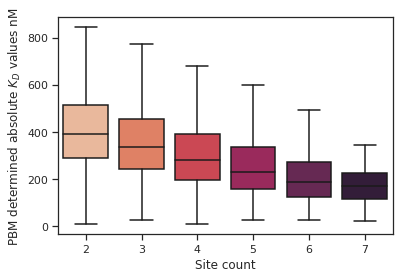

In [29]:
filtered = final_frame.loc[(final_frame['num_sites'] >= 1) & (final_frame['num_sites'] <= 7)]
#no_motif_halfsite = filtered.loc[filtered["Site_Type"].str.contains("Halfsite")]

ax = sns.boxplot(x="num_sites", y="kd", data= filtered, palette = "rocket_r", showfliers = False)
#ax.legend(['CGG half sites, Weak sites'])
ax.set_xlabel("Site count")
ax.set_ylabel(("PBM determined absolute $K_{D}$ values nM"))
#ax.set(xlim=(0,10))
plt.savefig("PBM_absolute_Kd.pdf")
#



In [ ]:
#count number of CGG half sites for sequences without a motif 
CGG_count = []
list_kd_nomotif = []
seq_type = []
for index,row in nomotif.iterrows():
    CGG_count.append(getCGG(row["sequence"]))
    list_kd_nomotif.append(cal_kd_pbm(FM,row["Power"],25))
    seq_type.append("Halfsite")


In [ ]:
nomotif["Count"] = CGG_count

In [ ]:
#two_sites = nomotif[nomotif["Count"]<= 2]

In [ ]:
# two_sites.groupby("Count").mean()
# two_mean = 343.997261

In [ ]:
# filtered_nomotif = nomotif[nomotif["Count"]>2]
# filtered_nomotif["BFS"] = filtered_nomotif["Power"] - two_mean

In [ ]:
# list_kd_nomotif = []
# seq_type = []
# for index,row in filtered_nomotif.iterrows():
#     list_kd_nomotif.append(cal_kd_pbm(FM,row["BFS"],25))
#     seq_type.append("Halfsite")



In [ ]:
nomotif["Kd"] = list_kd_nomotif
#df_weaksite2["Kd"] = list_kd_nomotif

In [ ]:
nomotif["Site_Type"] = seq_type

In [ ]:
new_df = nomotif[["SeqName", "Site_Type", "Count", "Kd"]]

In [ ]:
new_df

In [ ]:

officially_final = pd.concat([new_df])

In [ ]:
officially_final.to_csv("no_motif.csv",  sep=',')


In [ ]:
nomotif = pd.read_csv('no_motif.csv')

# Analyzing PBM data of bHLH TFs to compare with Gal4p

In [ ]:
nomotif_kdframe = pd.DataFrame(columns = ["Count", "Median Kd", "Mean Kd"])
for n in range (0,11):
	cursorFrame = nomotif[nomotif["Count"]==n]
	#print(cursorFrame)
	#print cursorFrame.shape
	itterFrame = pd.DataFrame([[n,cursorFrame["Kd"].median(),cursorFrame["Kd"].mean()]],columns = ["Count", "Median Kd", "Mean Kd"])
# 	itterFrame = pd.DataFrame([[n,cursorFrame["Power"].max(),cursorFrame["Power"].min()], np.mean(cursorFrame["Power"])],columns = ["Count", "Max Score", "Min Score", "mean"])
	nomotif_kdframe = nomotif_kdframe.append(itterFrame)



In [ ]:
nomotif_kdframe

In [ ]:
nomotif["relative_Kd"] = nomotif["Kd"]/res

In [ ]:
filtered = nomotif.loc[(nomotif['Count'] >= 1) & (nomotif['Count'] <= 9)]
no_motif_halfsite = filtered.loc[filtered["Site_Type"].str.contains("Halfsite")]

In [ ]:
no_motif_halfsite

In [ ]:
# nomotif_kdframe
# import seaborn as sns
filtered = nomotif.loc[(nomotif['Count'] >= 1) & (nomotif['Count'] <= 9)]
no_motif_halfsite = filtered.loc[filtered["Site_Type"].str.contains("Halfsite")]

ax = sns.boxplot(x="Count", y="Kd", data= no_motif_halfsite, palette = "rocket_r", showfliers = False)
#ax.legend(['CGG half sites, Weak sites'])
ax.set_xlabel("Site count")
ax.set_ylabel(("PBM determined $K_{D}$ values nM"))
#ax.set(xlim=(0,10))
#plt.savefig("halfsite_weaksite_compare_overlap_errorbars_filtered.pdf")
#


In [ ]:
no_motif_halfsite.groupby("Count").count()

In [ ]:
frame

In [ ]:
filteredframe = frame.loc[frame["num_sites"]<10]

In [ ]:
ax = sns.boxplot(x = "num_sites", y = "relative_kd", data = filteredframe, showfliers = False, palette = "rocket_r")
ax.set_xlabel("CGG Half site Number")
ax.set_ylabel(("PBM determined relative to consenus $K_{D}$ values nM"))
#plt.savefig("relative_Kd_PBM_halfsite_boxplot.pdf")

In [ ]:
ax = sns.boxplot(x = "num_sites", y = "relative_Kd", data = no_motif_halfsite, showfliers = False, palette = "rocket_r")
ax.set_xlabel("CGG Half site Number")
ax.set_ylabel(("PBM determined relative to consenus $K_{D}$ values nM"))

In [ ]:
withmotif["Kd"] = list_kd_withmotif

In [ ]:
withmotif["Kd"].max()

In [ ]:
df_final = add_pwm_info(df, "gal4", 13.01)

In [ ]:
with_motif_final  = df_final[df_final["Score"] >= 13.01]
with_motif_final

In [ ]:
CGG_count2 = []
#list_kd_nomotif = []
for index,row in with_motif_final.iterrows():
    CGG_count2.append(getCGG(row["Sequence"]))

In [ ]:
motif= CGG_count2

In [ ]:
withmotif["CGG_count"] = CGG_count2

In [ ]:
withmotif.sort("Kd")

In [ ]:
ax = sns.barplot(data = withmotif, x = "Score", y = "Kd", palette = "rocket_r")
ax.set_xlabel("Sequence with PWM score above 13.00")
ax.set_ylabel(("PBM determined $K_{D}$ values"))
#plt.savefig("Kd_PBM_withcanonsite_boxplot.pdf")

In [ ]:
def removeCACGTG(df):
	newdf = pd.DataFrame(columns = ["Name", "Sequence", "Alexa488", "Cy3"])
	for index,row in df.iterrows():
		if(row["Sequence"].find("CACGTG") < 0):
			itterFrame = pd.DataFrame([[row["Name"],row["Sequence"],row["Alexa488"],row["Cy3"]]],columns = ["Name", "Sequence", "Alexa488", "Cy3"])
			newdf = newdf.append(itterFrame)
	return newdf



def getCAC(inSeq):
	seq = Seq(str(inSeq), IUPAC.unambiguous_dna)
	n = 0
	while(seq.find("CAC")>=0):
		i = seq.find("CAC")
		seq = seq[i+3:]
		n = n+1
	seq = seq.reverse_complement()
	while(seq.find("CAC")>=0):
		i = seq.find("CAC")
		seq = seq[i+3:]
		n = n+1
	return n

def make_outputframe(finalFrame):
    outputFrame = pd.DataFrame(columns = ["Count", "Median Score", "Mean Score"])
    for n in range (0,6):
        cursorFrame = finalFrame[finalFrame["Count"]==n]
        itterFrame = pd.DataFrame([[n,cursorFrame["Power"].median(),cursorFrame["Power"].mean()]],columns = ["Count", "Median Score", "Mean Score"])
        outputFrame = outputFrame.append(itterFrame)
    return outputFrame 

In [8]:
df = pd.read_csv("Tye7-9_rawdata.txt", delimiter = "\t",index_col=0)
df = removeEnd(df)
# df = removeCannon(df)
df = removeCACGTG(df)

finalFrame_tye7nocanon = pd.DataFrame(columns = ["SeqName", "Count", "Power"])  
for index,row in df.iterrows():
	if row["Sequence"] != "_" and row["Name"].find("deBruijn") >= 0:
		itterFrame = pd.DataFrame([[row["Name"],getCAC(row["Sequence"]), (float(row["Alexa488"])/row["Cy3"])*1000]], columns = ["SeqName",  "Count", "Power"])
		finalFrame_tye7nocanon = finalFrame_tye7nocanon.append(itterFrame)



# outputFrame = pd.DataFrame(columns = ["Count", "Median Score", "Mean Score"])
# for n in range (0,7):
# 	cursorFrame = finalFrame[finalFrame["Count"]==n]
# 	itterFrame = pd.DataFrame([[n,cursorFrame["Power"].median(),cursorFrame["Power"].mean()]],columns = ["Count", "Median Score", "Mean Score"])
# 	outputFrame = outputFrame.append(itterFrame)

    
    
#outputFrame.to_csv("")    
#outputFrame.to_csv("HScontroltest.txt", sep = '\t')

In [11]:
outputframe_tye7nocanon= make_outputframe(finalFrame_tye7nocanon)
outputframe_tye7nocanon
#outputframe_tye7nocanon.to_csv("outputframe_tye7nocanon.csv", sep = ',')


,Count,Median Score,Mean Score
0,0.0,656.395280,831.537091
0,1.0,720.690969,1052.751515
0,2.0,790.633248,1339.406748
0,3.0,914.308829,1889.276220
0,4.0,884.669203,2159.178777
0,5.0,5430.075532,5236.932186


In [14]:
df = pd.read_csv("Gal4-9_rawdata.txt", delimiter = "\t",index_col=0)
df2 = add_recommended_score(df)


In [15]:
df2[df2["Score"]<=13]

,Row,Name,ID,Sequence,Cy3,Cy3Flags,Alexa488,Alexa488Flags,Score
Column,,,,,,,,,
1,1,GE_BrightCorner,GE_BrightCorner,_,123,0,31316,0,-56.28
2,1,GE_BrightCorner,GE_BrightCorner,_,120,0,28918,0,-56.28
3,1,DarkCorner,DarkCorner,_,61,0,3588,0,-56.28
4,1,DarkCorner,DarkCorner,_,29,0,3593,0,-56.28
5,1,DarkCorner,DarkCorner,_,121,0,2634,0,-56.28
6,1,DarkCorner,DarkCorner,_,144,0,4158,0,-56.28
7,1,DarkCorner,DarkCorner,_,16,0,3670,0,-56.28
8,1,DarkCorner,DarkCorner,_,36,0,4595,0,-56.28
9,1,DarkCorner,DarkCorner,_,94,0,4364,0,-56.28


In [16]:
# nosite = df2[df2["Score"]<= 13.0]
nosite = removeEnd(df2)


finalFrame_nosite = pd.DataFrame(columns = ["SeqName", "Count", "Power"])  
for index,row in nosite.iterrows():
	if row["Sequence"] != "_" and row["Name"].find("deBruijn") >= 0:
		itterFrame = pd.DataFrame([[row["Name"],getCGG(row["Sequence"]), (float(row["Alexa488"])/row["Cy3"])*1000]], columns = ["SeqName",  "Count", "Power"])
		finalFrame_nosite = finalFrame_nosite.append(itterFrame)

In [17]:
outputframe_noCGG = make_outputframe(finalFrame_nosite)
outputframe_noCGG
#outputframe_nogal4canon = make_outputframe(finalFrame_Gal4nocanon)
#outputframe_noCGG.to_csv("output_noCGG.csv", sep = ',')

,Count,Median Score,Mean Score
0,0.0,306.021074,340.008544
0,1.0,355.457845,400.708437
0,2.0,428.168235,487.117368
0,3.0,526.352457,602.523710
0,4.0,642.763072,739.554013
0,5.0,745.152722,852.542997


In [ ]:
outputframe_withgal4canon= make_outputframe(finalFrame_withCGG_N11_CCG)
outputframe_withgal4canon.to_csv("output_withGal4canon.csv", sep = ',')

In [ ]:
outputframe_nogal4canon = make_outputframe(finalFrame_Gal4nocanon)
#outputframe_nogal4canon.to_csv("output_nogal4canon.csv", sep = ',')